<a href="https://colab.research.google.com/github/pranalitalla8/OpenCV_High_Resolution_Colorization/blob/main/cesium_mars_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ### Project Approach: High-Resolution Mars Imagery Colorization

Using a high-resolution, black-and-white JPEG image with a low-resolution color GeoTIFF to create a sharp, colorized GeoTIFF output for a specific region of Mars.

This strategy combines geospatial tools (Rasterio) for location data handling with computer vision libraries (OpenCV, scikit-image) for sophisticated color transfer.

In [ ]:
#!pip install rasterio
#!pip install skimage

In [ ]:
import rasterio
import numpy as np
import cv2
import skimage
import matplotlib.pyplot as plt


In [ ]:
from rasterio.warp import reproject, Resampling
from skimage.exposure import match_histograms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
high_res_bw_path = '/content/drive/MyDrive/bentley_cesium/Data/high-res-bw.tif'
low_res_color_path = '/content/drive/MyDrive/bentley_cesium/Data/low-res-colored.tif'
output_path = '/content/drive/MyDrive/bentley_cesium/Data/output.tif'

Explore input tif files using rasterio

In [ ]:
tif1 = rasterio.open(high_res_bw_path)
tif2 = rasterio.open(low_res_color_path)

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
print(tif1.shape)
print(tif2.shape)
#print(dir(tif1))
print("meta:", tif1.meta)
print("bands:",tif1.count)
print("size:",tif1.width, tif1.height)
print("crs:", tif1.crs)
print("bounds",tif1.bounds)
print("transform",tif1.transform)
print("dtypes:",tif1.dtypes)
print("meta2:",tif2.meta)
print("bands2:",tif2.count )
print("size2:",tif2.width, tif2.height)
print("crs2:", tif2.crs)
print("bounds2",tif2.bounds)
print("transform2",tif2.transform)
print("dtypes2:",tif2.dtypes)


(600, 960)
(60, 81)
meta: {'driver': 'JPEG', 'dtype': 'uint8', 'nodata': None, 'width': 960, 'height': 600, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}
bands: 1
size: 960 600
crs: None
bounds BoundingBox(left=0.0, bottom=600.0, right=960.0, top=0.0)
transform | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
dtypes: ('uint8',)
meta2: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 81, 'height': 60, 'count': 3, 'crs': CRS.from_wkt('PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(100.0, 0.0, 8161847.998780876,
       0.0, -100.0, -2

### Read Input Files
Read images. The high-res B&W image is a standard JPEG. The low-res color image is a georeferenced GeoTIFF (contains location data).



> opencv, rasterio



In [ ]:
with rasterio.open(low_res_color_path) as lr:
  lr_image = lr.read()
  lr_meta = lr.meta

  lr_rgb = np.moveaxis(lr_image, 0, -1)  # Convert to HxWx3 for OpenCV
  lr_crs = lr.crs
  lr_bounds = lr.bounds
  lr_meta = lr.meta


print(lr_meta)
print(lr_image.shape)
print(lr_rgb.shape)
print("Low-res color shape:", lr_rgb.shape)
print("Low-res CRS:", lr_crs)
print("Low-res bounds:", lr_bounds)
print("Low-res metadata:", lr_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 81, 'height': 60, 'count': 3, 'crs': CRS.from_wkt('PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(100.0, 0.0, 8161847.998780876,
       0.0, -100.0, -253769.7987616388)}
(3, 60, 81)
(60, 81, 3)
Low-res color shape: (60, 81, 3)
Low-res CRS: PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["fals

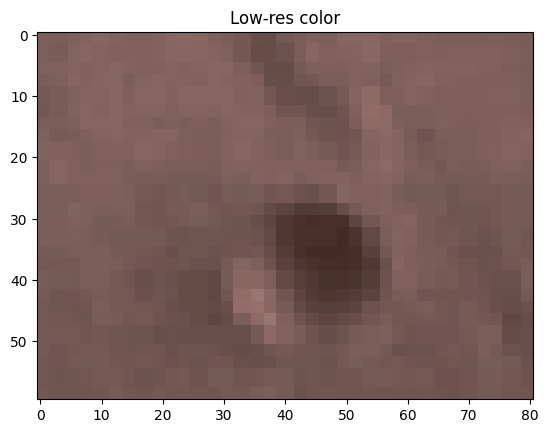

In [ ]:
# Display LR color
plt.figure()
plt.title("Low-res color")
plt.imshow(lr_rgb)
plt.show()

In [ ]:
hr_img = cv2.imread(high_res_bw_path, cv2.IMREAD_GRAYSCALE)
H_height, H_width = hr_img.shape
print("High-res shape:", hr_img.shape)

High-res shape: (600, 960)


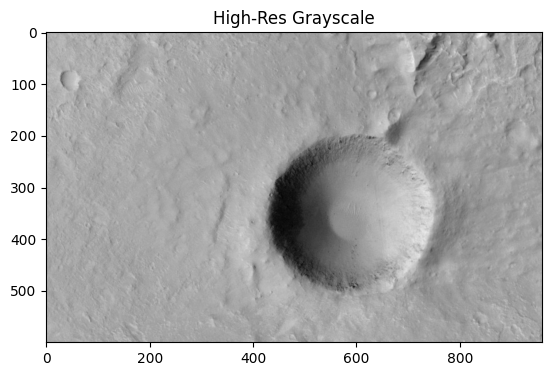

In [ ]:
# Display HR grayscale
plt.figure()
plt.title("High-Res Grayscale")
plt.imshow(hr_img, cmap="gray")
plt.show()

### Align Data

Resize the low-resolution color data to match the exact pixel dimensions of the high-resolution JPEG. This is a simple image resize, not geospatial alignment yet.



> opencv



In [ ]:
lr_resized = cv2.resize(lr_rgb, (H_width, H_height), interpolation=cv2.INTER_CUBIC)
print("LR resized shape:", lr_resized.shape)

LR resized shape: (600, 960, 3)


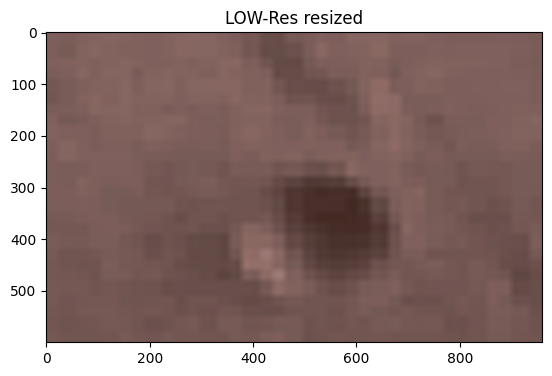

In [ ]:
plt.figure()
plt.title("LOW-Res resized")
plt.imshow(lr_resized)
plt.show()

### Convert to L\*a\*b*

Convert the resized low-res image to the  **L\*a\*b*** color space from OpenCV. This separates the L* channel (Lightness/Brightness/Detail) from the a*, b* channels (Chrominance/Color details).



> opencv






In [ ]:
lr_lab = cv2.cvtColor(lr_resized, cv2.COLOR_RGB2LAB)
L_lr = lr_lab[:,:,0]
a_lr = lr_lab[:,:,1]
b_lr = lr_lab[:,:,2]

###Histogram Matching

Statistically match the brightness (luminance) profile of the high-resolution B&W JPEG to the statistics of the low-resolution L* channel. This ensures the output image has a realistic range of brightness values.

https://www.geeksforgeeks.org/python/histogram-matching-with-opencv-scikit-image-and-python/


> scikit-image match_histograms



In [ ]:
hr_L = hr_img.astype(np.uint8)
L_matched = match_histograms(hr_L, L_lr.astype(np.uint8), channel_axis=None)

##Refine Chroma Channels (Bilateral Filter)
Apply a bilateralFilter to the a*, b* color channels. This is an edge-preserving filter that smooths colors while maintaining sharp boundaries defined by the luminance channel.


> opencv



In [ ]:
#smooth chroma channels
a_smooth = cv2.bilateralFilter(a_lr.astype(np.uint8), d=7, sigmaColor=50, sigmaSpace = 50)
b_smooth = cv2.bilateralFilter(b_lr.astype(np.uint8), d=7, sigmaColor=50, sigmaSpace = 50)

###Reconstruct & Save

Combine the high-res matched luminance (L*) with the smoothed chrominance (a*, b*). Save the resulting RGB data as a GeoTIFF, incorporating the original geospatial metadata (bounds, CRS) from the low-res input.



> numpy, opencv, rasterio



In [ ]:
lab_out = np.stack([L_matched.astype(np.uint8), a_smooth, b_smooth], axis=-1)
rgb_out = cv2.cvtColor(lab_out, cv2.COLOR_Lab2RGB)

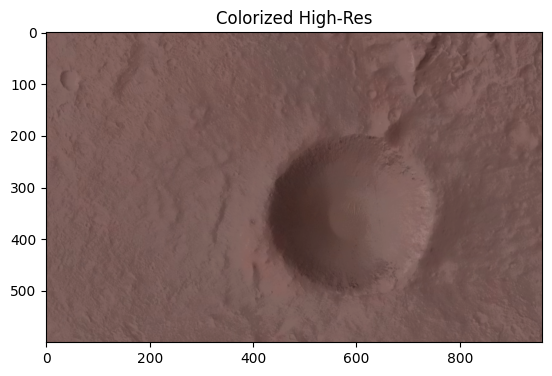

In [ ]:
plt.figure()
plt.title("Colorized High-Res")
plt.imshow(rgb_out)
plt.show()

Save to GeoTiff

In [ ]:
transform_new = rasterio.transform.from_bounds(
    lr_bounds.left, lr_bounds.bottom, lr_bounds.right, lr_bounds.top, H_width, H_height
)

In [ ]:
meta = {
    "driver":"GTiff",
    "height": H_height,
    "width": H_width,
    "count":3,
    "dtype": "uint8",
    "crs":lr_crs,
    "transform":transform_new
}

In [ ]:
with rasterio.open(output_path, "w", **meta) as out:
  #out.write(rgb_out.astype(rasterio.uint8))
  # rasterio expects shape: (bands, height, width)
  out.write(np.moveaxis(rgb_out, -1, 0))

In [ ]:
with rasterio.open(output_path, "r") as out1:
  out1_image = out1.read()
  out1_meta = out1.meta
  print(out1_meta)
  print(out1_image.shape)
  out1_rgb = np.moveaxis(out1_image, 0, -1)  # Convert to HxWx3 for OpenCV

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 960, 'height': 600, 'count': 3, 'crs': CRS.from_wkt('PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(8.4375, 0.0, 8161847.998780876,
       0.0, -10.0, -253769.7987616388)}
(3, 600, 960)


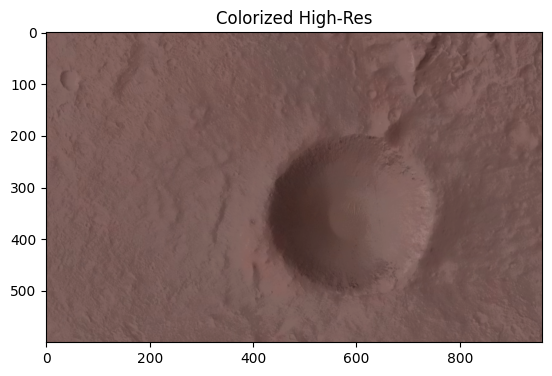

In [ ]:
#Display the image
plt.figure()
plt.title("Colorized High-Res")
plt.imshow(out1_rgb)
plt.show()

### Experimenting with Bilateral , Guided Filter for Chroma colors

In [ ]:

try:
    from cv2.ximgproc import guidedFilter
    guided_available = True
except ImportError:
    guided_available = False
    print("Guided filter not available. Only bilateral will work.")

print(guided_available)

True


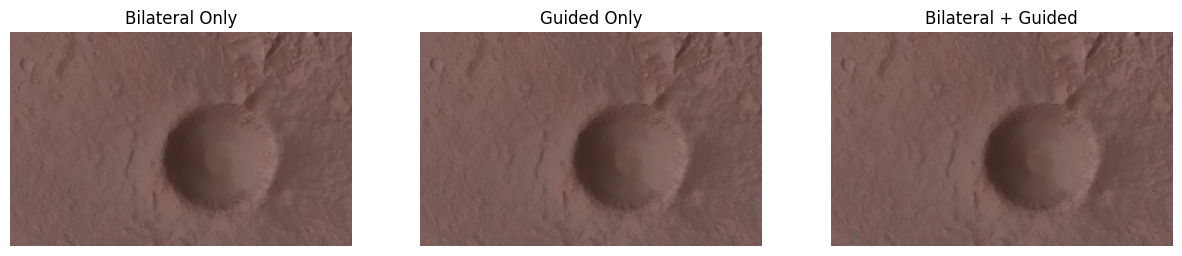

In [ ]:
# -----------------------------
# FILTERING EXPERIMENTS
# -----------------------------
# --- Method 1: Bilateral Only ---
a_bilat = cv2.bilateralFilter(a_lr.astype(np.uint8), d=7, sigmaColor=50, sigmaSpace=50)
b_bilat = cv2.bilateralFilter(b_lr.astype(np.uint8), d=7, sigmaColor=50, sigmaSpace=50)
lab_bilat = np.stack([L_matched.astype(np.uint8),
                      a_bilat.astype(np.uint8),
                      b_bilat.astype(np.uint8)], axis=-1)
rgb_bilat = cv2.cvtColor(lab_bilat, cv2.COLOR_Lab2RGB)

# --- Method 2: Guided Only (if available) ---
if guided_available:
    radius = 8
    eps = 1e-2 * 255 * 255
    a_guide = guidedFilter(guide=hr_L, src=a_lr.astype(np.uint8), radius=radius, eps=eps)
    b_guide = guidedFilter(guide=hr_L, src=b_lr.astype(np.uint8), radius=radius, eps=eps)

    lab_guide = np.stack([L_matched.astype(np.uint8),
                          a_guide.astype(np.uint8),
                          b_guide.astype(np.uint8)], axis=-1)
    rgb_guide = cv2.cvtColor(lab_guide, cv2.COLOR_Lab2RGB)

# --- Method 3: Bilateral + Guided ---
if guided_available:
    a_bilat2 = cv2.bilateralFilter(a_lr.astype(np.uint8), d=7, sigmaColor=50, sigmaSpace=50)
    b_bilat2 = cv2.bilateralFilter(b_lr.astype(np.uint8), d=7, sigmaColor=50, sigmaSpace=50)
    a_combo = guidedFilter(guide=hr_L, src=a_bilat2.astype(np.uint8), radius=radius, eps=eps)
    b_combo = guidedFilter(guide=hr_L, src=b_bilat2.astype(np.uint8), radius=radius, eps=eps)

    lab_combo = np.stack([L_matched.astype(np.uint8),
                          a_combo.astype(np.uint8),
                          b_combo.astype(np.uint8)], axis=-1)
    rgb_combo = cv2.cvtColor(lab_combo, cv2.COLOR_Lab2RGB)

# -----------------------------
#  DISPLAY RESULTS
# -----------------------------
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Bilateral Only")
plt.imshow(rgb_bilat)
plt.axis("off")

if guided_available:
    plt.subplot(1,3,2)
    plt.title("Guided Only")
    plt.imshow(rgb_guide)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Bilateral + Guided")
    plt.imshow(rgb_combo)
    plt.axis("off")

plt.show()
